# Statsmodel-SARIMAX model

In [1]:
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

## Data loading

In [2]:
df = pd.read_csv('./data/AirPassengers.csv')
df

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [3]:
df['Month']= pd.to_datetime(df['Month'])
df = df.set_index('Month')
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## Preprocessing Data

In [4]:
df.isnull().sum()

#Passengers    0
dtype: int64

<Axes: xlabel='Month'>

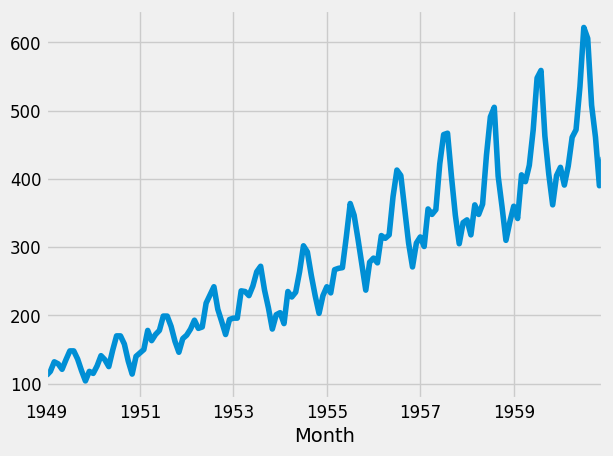

In [5]:
df['#Passengers'].plot()

## TimeSeries Decomposition 

Time series decomposition helps us break down a time series dataset into three main components:

**Trend**: The trend component represents the long-term movement in the data, representing the underlying pattern.
**Seasonality**: The seasonality component represents the repeating, short-term fluctuations caused by factors like seasons or cycles.
**Residual (Noise)**: The residual component represents random variability that remains after removing the trend and seasonality.

### STL decomposition

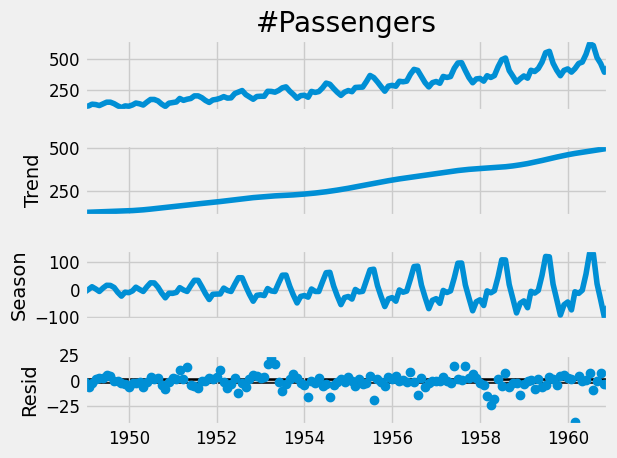

In [6]:
from statsmodels.tsa.seasonal import STL

# Perform STL decomposition
stl = STL(df['#Passengers'], seasonal=13, robust=True)
stl_series = stl.fit()
# Plot the decomposition components
stl_series.plot()
plt.show()


## Stationarity

### Augmented Dickey-Fuller (ADF)

#### ADF test

In [7]:
from statsmodels.tsa.stattools import adfuller

def perform_adf_test(timeseries: pd.Series) -> None:
  result = adfuller(timeseries)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

perform_adf_test(df['#Passengers'])

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


The dataset is **NOT** stationary

### Making stationary time series

* **Differencing** <br>

* **Seasonal Differencing** <br>


In [8]:
# 1st differencing
df['diff'] = df['#Passengers'] - df['#Passengers'].shift(1)

# seasonal differencing
n = 12
df['seasonal_diff'] = df['#Passengers'] - df['#Passengers'].shift(n)

print('ADF test with 1st differencing')
perform_adf_test(df['diff'].dropna())
print('\n')
print('ADF test with seasonal differencing')
perform_adf_test(df['seasonal_diff'].dropna())
print('\n')


# differencing and seasonal differencing
df['diff_seasonal_diff'] = df['diff'] - df['diff'].shift(n)
print('ADF test with differencing plus seasonal differencing')
perform_adf_test(df['diff_seasonal_diff'].dropna())
print('\n')

ADF test with 1st differencing
ADF Statistic: -2.829267
p-value: 0.054213
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


ADF test with seasonal differencing
ADF Statistic: -3.383021
p-value: 0.011551
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


ADF test with differencing plus seasonal differencing
ADF Statistic: -15.595618
p-value: 0.000000
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579




Set d = 1 and D = 1

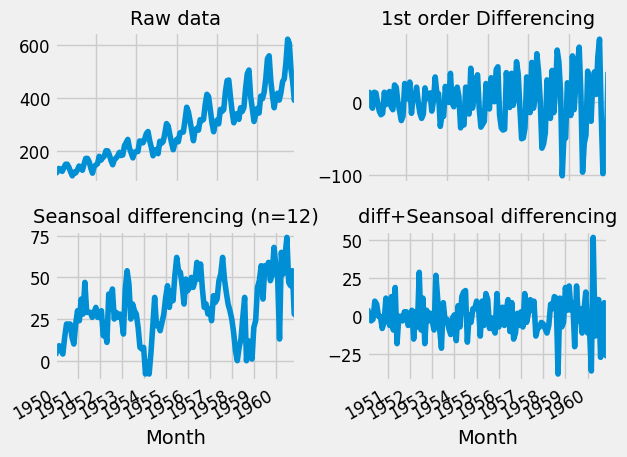

In [9]:
fig, ax = plt.subplots(2,2, tight_layout=True)

# original plot
df['#Passengers'].dropna().plot(ax=ax[0,0])
ax[0,0].set_title('Raw data', fontsize=14)

# differencing
df['diff'].dropna().plot(ax=ax[0,1])
ax[0,1].set_title('1st order Differencing', fontsize=14)

# seasonal differencing (n =12)

df['seasonal_diff'].dropna().plot(ax=ax[1,0])
ax[1,0].set_title('Seansoal differencing (n=12)', fontsize=14)

# defferencing and seasonal differencing
df['diff_seasonal_diff'].dropna().plot(ax=ax[1,1])
ax[1,1].set_title('diff+Seansoal differencing',fontsize=14)

fig.autofmt_xdate()
plt.tight_layout()


## Autocorrelation (ACF) and partial autocorrelation (PACF)

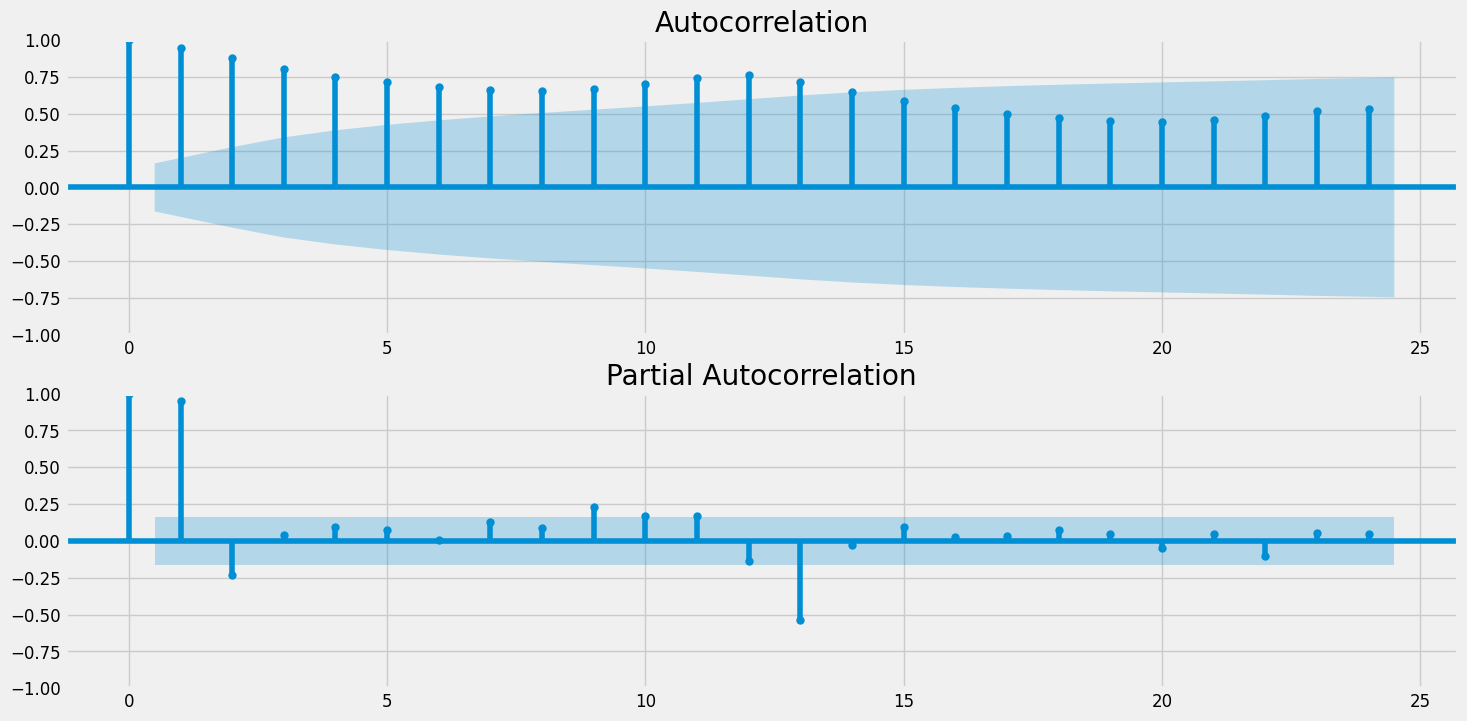

In [10]:
import statsmodels.graphics.api as smg
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

lags = 24
plot_acf(df['#Passengers'], lags=lags, ax=ax[0])
plot_pacf(df['#Passengers'], lags=lags, ax=ax[1])
plt.show()

## SARIMA model

In [11]:
from statsmodels.tools.eval_measures import rmse
# semi-grid-searching SARIMA parameters
def SARIMA_grid(endog: (pd.Series | list), order_list: list, d: int, D: int, m: int):

    # create an empty list to store parameter values
    model_info = []

    #fit the model
    for order in tqdm(order_list):
        try:
            model = sm.tsa.statespace.SARIMAX(endog=endog,
                                              order=(order[0],d,order[1]),
                                              seasonal_order=(order[2],D,order[3],m))
            result = model.fit(disp=0)
            predict = result.predict()

            # calculate evaluation metrics: RMSE & AIC
            RMSE = rmse(endog[1:], predict[1:])
            AIC = result.aic

            # create a list of order, seasonal order & evaluation metrics
            info = [order,d,D,m,RMSE, AIC]
            model_info.append(info)

        except:
            continue

    # create a dataframe to store info of all models
    columns = ['(p,q,P,Q)','d','D','m', 'RMSE', 'AIC']
    model_info = pd.DataFrame(data=model_info, columns=columns)
    return model_info

In [12]:
y = df.copy()
train = y.loc[:'1957-12-01','#Passengers'].dropna()
test = y['#Passengers']['1958-01-01':]
print(f'orginal data: {y.shape}\ntrain data: {train.shape}\ntest data: {test.shape}')

orginal data: (144, 4)
train data: (108,)
test data: (36,)


In [13]:
# possible values of the parameters
ps = qs = Ps = Qs = range(0,4,1)
SARIMA_order_list = list(itertools.product(ps,qs,Ps,Qs))

d= 1
D = 1
m = 12

# fit all combinations into the model
model_info = SARIMA_grid(endog=train, order_list=SARIMA_order_list, d=d,D=D,m=m)

  0%|          | 0/256 [00:00<?, ?it/s]

In [14]:
# least RMSE model
L1 = model_info[model_info.RMSE == model_info.RMSE.min()]
# least AIC model
L2 = model_info[model_info.AIC == model_info.AIC.min()]

df_model_params =pd.concat((L1, L2))

In [15]:
df_model_params

,"(p,q,P,Q)",d,D,m,RMSE,AIC
249,"(3, 3, 2, 2)",1,1,12,10.678234,702.467464
54,"(0, 3, 1, 2)",1,1,12,10.810804,699.398688


In [16]:
df_model_params

,"(p,q,P,Q)",d,D,m,RMSE,AIC
249,"(3, 3, 2, 2)",1,1,12,10.678234,702.467464
54,"(0, 3, 1, 2)",1,1,12,10.810804,699.398688


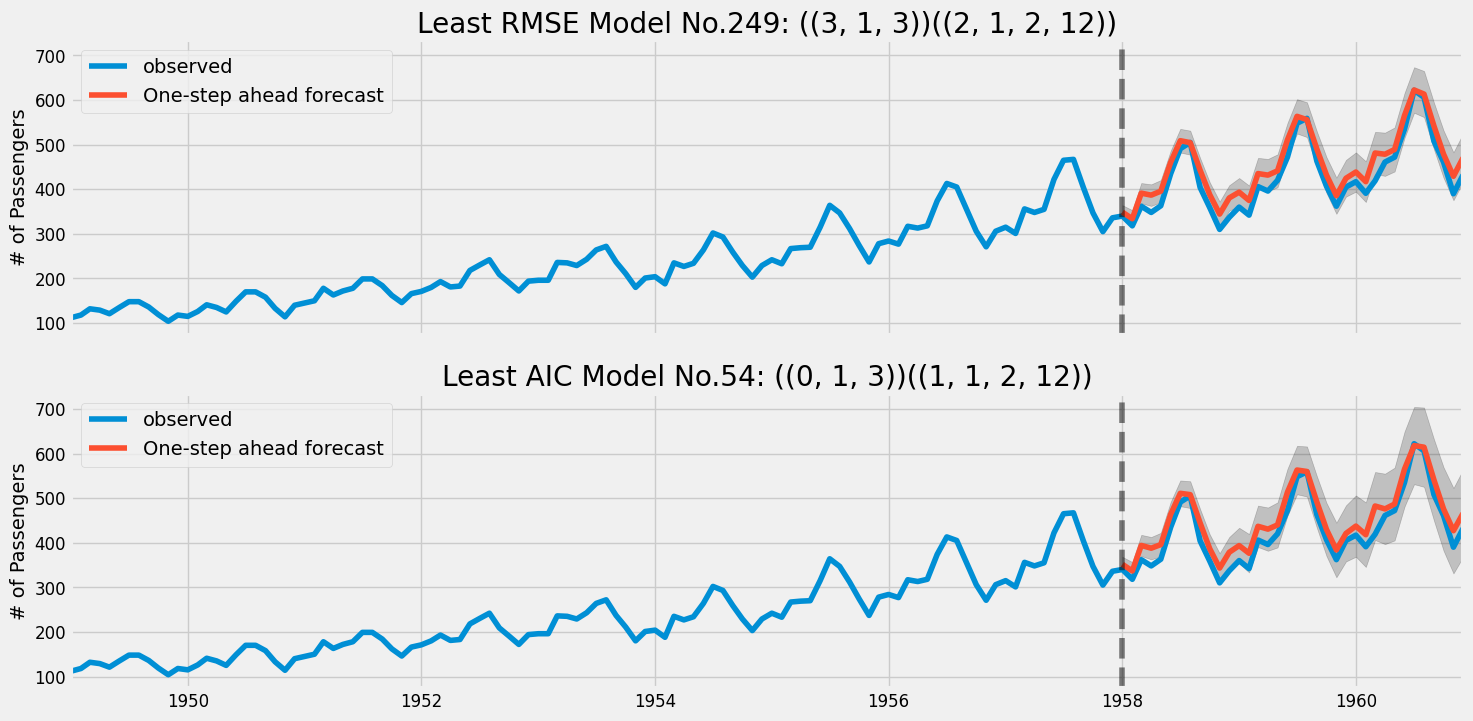

In [17]:
# fit the models of different order and seasonal order
parameters = df_model_params['(p,q,P,Q)'].tolist()

df_model_params.loc[:,'order'] = [(parameters[x][0],d,parameters[x][1]) for x in range(2)]
order_list = df_model_params['order'].tolist()


df_model_params.loc[:,'seasonal_order'] = [(parameters[x][2],D,parameters[x][3],m) for x in range(2)]
seasonal_order_list = df_model_params['seasonal_order'].tolist()

ids = df_model_params.index.tolist()
model_types = ['RMSE','AIC']
titles=[f'Least {model_types[x]} Model No.{ids[x]}: ({order_list[x]})({seasonal_order_list[x]})' for x in range(2)]

#prediction start/end
pred_start = '1958-01-01'
pred_end = '1960-12-01'

pred_list = []
y_lower_ci = [] # prediction confidence interval lower boundary
y_upper_ci = [] # prediction confidence interval upper boundary

for i in range(2):
    model = sm.tsa.statespace.SARIMAX(endog=train, order=order_list[i],
                                      seasonal_order=seasonal_order_list[i])
    result = model.fit(disp=0)

    pred_summary = result.get_prediction(start=pred_start, end=pred_end, dynamic=False).summary_frame()
    pred_list.append(pred_summary['mean'])
    y_lower_ci.append(pred_summary['mean_ci_lower'][pred_summary.index])
    y_upper_ci.append(pred_summary['mean_ci_upper'][pred_summary.index])


# visualize the results of the fitted models
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(16,8),
                        sharex=True, sharey=True)
k = 0
for i in range(2):
    axs[i].plot(y['#Passengers'], label='observed')
    axs[i].plot(pred_list[k], label='One-step ahead forecast')
    axs[i].set_title(titles[k])
    axs[i].set_ylabel('# of Passengers')
    axs[i].legend()
    axs[i].axvline(pred_summary.index[0], color='black', alpha=0.5, linestyle='--')
    axs[i].fill_between(x=pred_summary.index, y1=y_lower_ci[k], y2=y_upper_ci[k], color='k', alpha=0.2)
    # axs[i,j].set_ylim(bottom=0, top=2500)
    axs[i].set_xlim(left=y.index[0], right=y.index[-1])
    k += 1
plt.show()

In [18]:
# Leat AIC model No. 54
index = 54
order = df_model_params.loc[index,'order']
seasonal_order = df_model_params.loc[index,'seasonal_order']


mod = sm.tsa.statespace.SARIMAX(train,
                                order=order,
                                seasonal_order=seasonal_order)
results = mod.fit(disp=0)
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3375      0.108     -3.117      0.002      -0.550      -0.125
ma.L2          0.1061      0.134      0.794      0.427      -0.156       0.368
ma.L3         -0.2723      0.137     -1.981      0.048      -0.542      -0.003
ar.S.L12       0.9988      0.247      4.046      0.000       0.515       1.483
ma.S.L12      -1.3548      3.280     -0.413      0.680      -7.783       5.073
ma.S.L24       0.3764      1.104      0.341      0.733      -1.787       2.540
sigma2        66.2688    204.152      0.325      0.745    -333.862     466.399


### Diagnostic plot

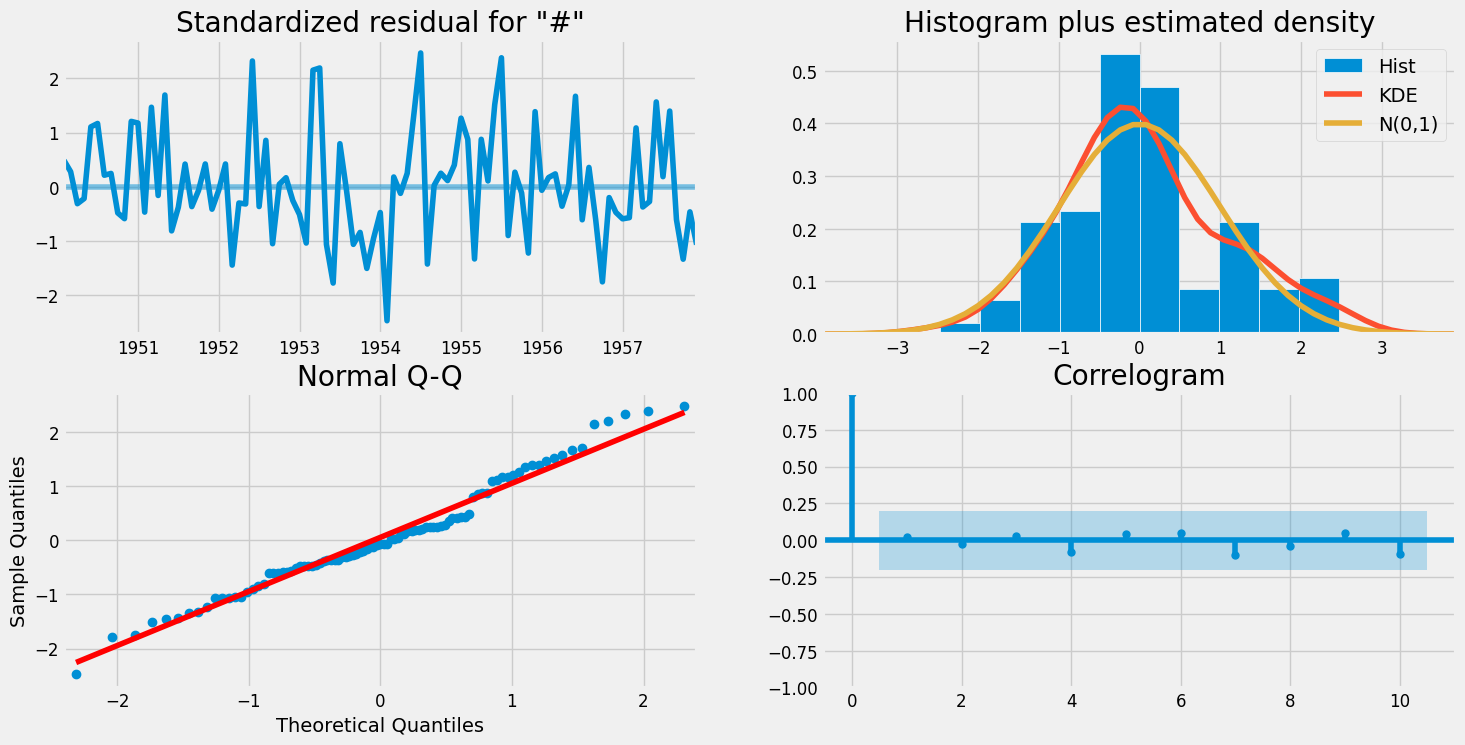

In [19]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [20]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residuals = results.resid
acorr_ljungbox(residuals, np.arange(1,11,1))

,lb_stat,lb_pvalue
1,0.002183,0.962736
2,0.518331,0.771695
3,0.580005,0.900994
4,0.690823,0.952456
5,1.072479,0.956511
6,1.196742,0.977045
7,1.862411,0.967061
8,2.470545,0.963090
9,2.781425,0.972334
10,4.630354,0.914465


There is no discernible pattern in the residual plot and Ljung-Box test fails to reject the null hypothesis. Thus, the residual is independent, uncorrelated and normally distributed.

## Model Validation

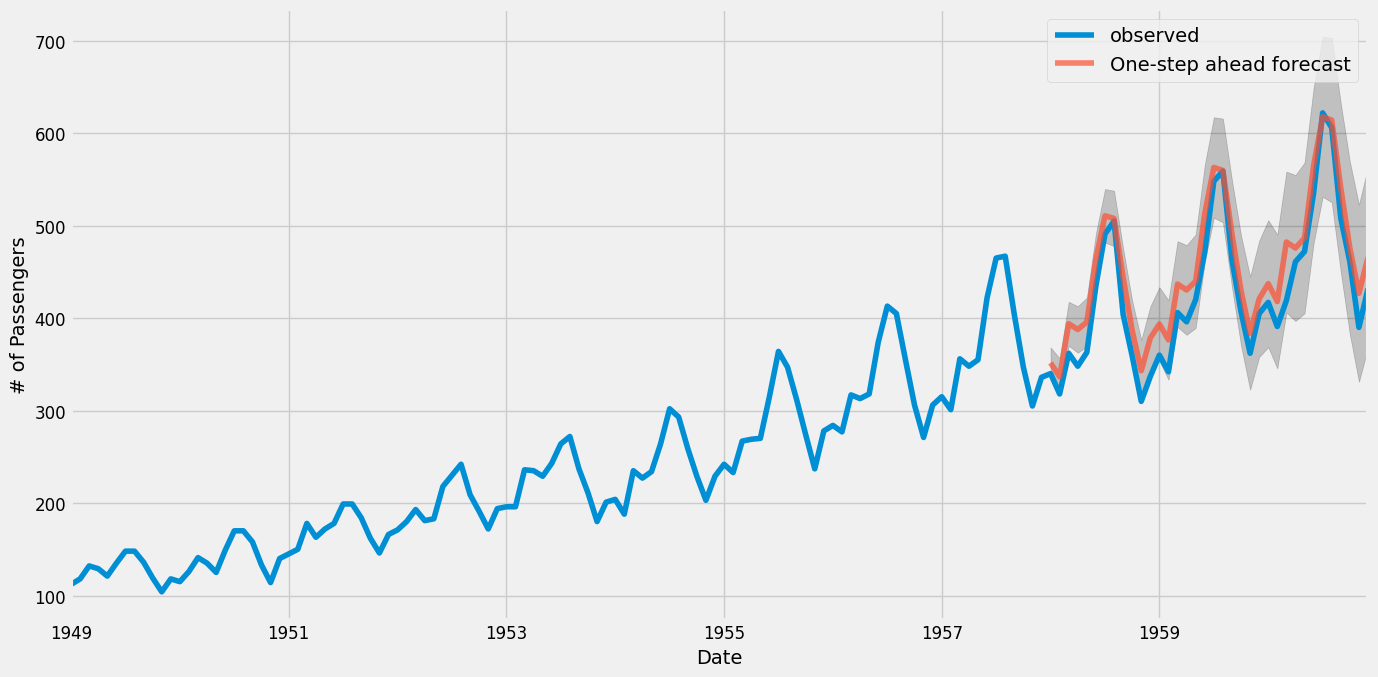

In [21]:
pred = results.get_prediction(start=pred_start, end=pred_end, dynamic=False)
pred_ci = pred.conf_int()
ax = y['#Passengers'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('# of Passengers')
plt.legend()

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

### Mean squared error (MSE) and root mean squared error (RMSE)

In [22]:
y_forecasted = pred.predicted_mean
y_truth = df['#Passengers']['1958-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print(f'The Mean Squared Error of our forecasts is {mse:.2f}')
print(f'The Root Mean Squared Error of our forecasts is {np.sqrt(mse):.2f}')

The Mean Squared Error of our forecasts is 827.09
The Root Mean Squared Error of our forecasts is 28.76


## Forecasting

Out-ouf-sample forecasts are produced using the `forecast` or `get_forecast` methods.

* **forecast**: one-step-ahead forecast <br>

* **get_forecast**: more general forecasting with confidence intervals<br>

In [23]:
# get a one-step-ahead forecast
print(results.forecast())

1958-01-01    351.633897
Freq: MS, dtype: float64


get_forecasting in statsmodels

`SARIMAXResults.get_forecast(steps=1, signal_only=False, **kwargs)`

Parameters:
* **steps**: If an integer, the number of steps to forecast from the end of the sample

*Prediction vs Forecasting*

In-sample fitted values, you could use `predict` and `get_prediction` similar to `forecast` and `get_forecast`. In general, if your interest is out-of-sample forecasting, it is easier to stick to the `forecast` and `get_forecast` methods.

Reference: [SARIMAXResutls.get_forecast()](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.get_forecast.html)

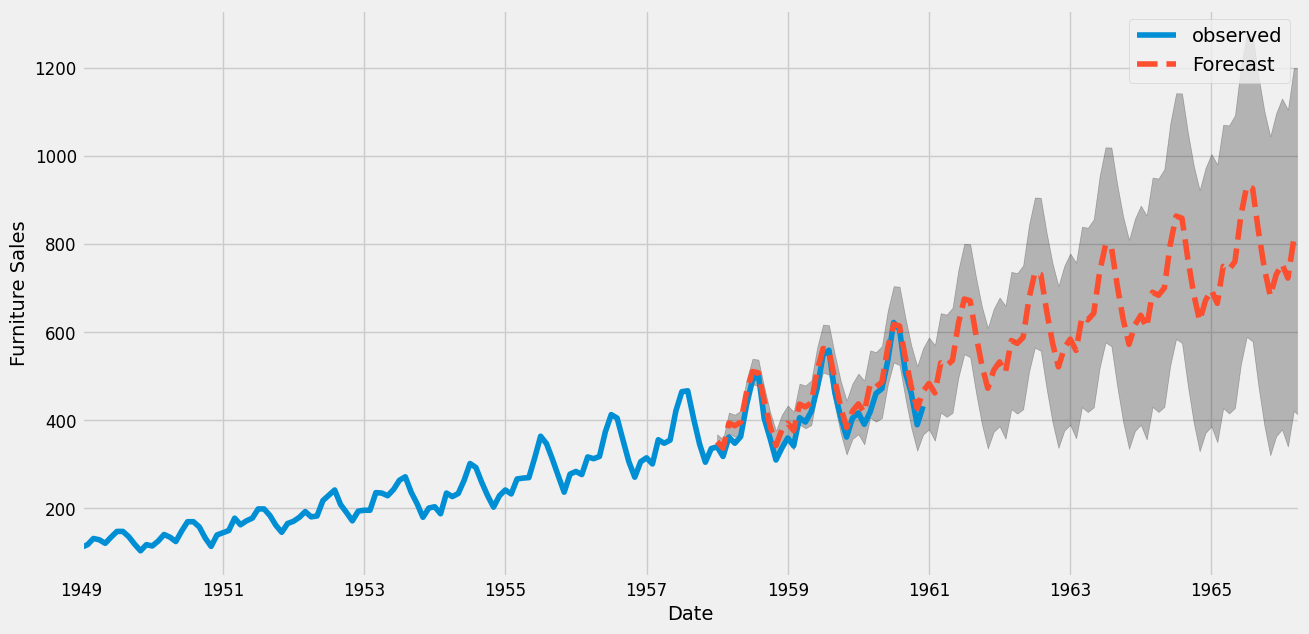

In [24]:
# steps indicating the 100 steps to forecast from the end of the sample
pred_uc = results.get_forecast(steps=100)

# summary frame contains predicted values
# default alpha parameter for confidence interval is 95% (0.95)
# display(pred_uc.summary_frame())

pred_ci = pred_uc.conf_int()
ax = df['#Passengers'].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', style='--')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25) # alpha is an opacity parameter not a confidence interval parameter
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

The model capture the seasonal pattern. As we forecast further in the future, it is natural that the model is less confidence in prediction. 

# Chronos

>Chronos is a family of pretrained time series forecasting models based on language model architectures. A time series is transformed into a sequence of tokens via scaling and quantization, and a language model is trained on these tokens using the cross-entropy loss. Once trained, probabilistic forecasts are obtained by sampling multiple future trajectories given the historical context. Chronos models have been trained on a large corpus of publicly available time series data, as well as synthetic data generated using Gaussian processes.

1. [Chronos: Learning the language of time series](https://www.amazon.science/code-and-datasets/chronos-learning-the-language-of-time-series)
2. [Chronos-T5 (Large)](https://huggingface.co/amazon/chronos-t5-large)

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    root_mean_squared_error,
)
import torch
from chronos import ChronosPipeline

<Axes: xlabel='Month'>

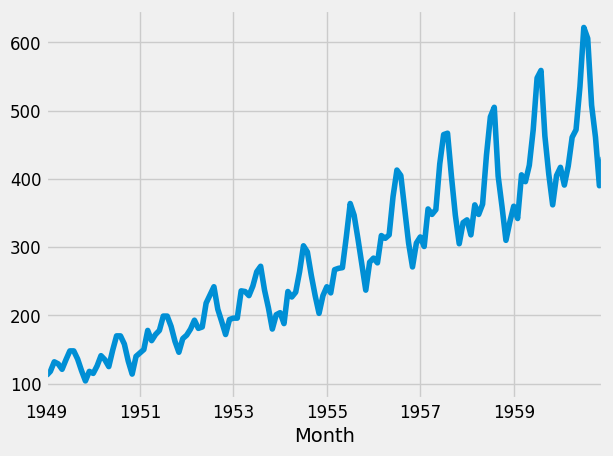

In [26]:
# データセットの目視確認
df['#Passengers'].plot()

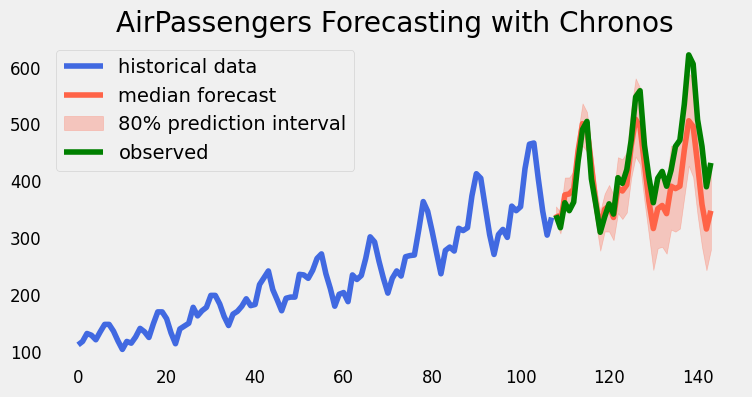

In [27]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="auto",
)

PREDICTION_LENGTH = 36
train = df["#Passengers"].values[:-PREDICTION_LENGTH]
val = df["#Passengers"].values[-PREDICTION_LENGTH:]

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(train)

forecast = pipeline.predict(
    context,
    PREDICTION_LENGTH,
    num_samples=100,
)  # shape [num_series, num_samples, PREDICTION_LENGTH]

# visualize the forecast
forecast_index = range(len(train), len(train) + PREDICTION_LENGTH)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(train, color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(
    forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval"
)
plt.plot(range(len(train), len(train) + len(val)), val, color="green", label="observed")
plt.legend()
plt.title("AirPassengers Forecasting with Chronos")
plt.grid()
plt.show()

In [28]:
forecast.shape

torch.Size([1, 100, 36])

In [29]:
def evaluate_model(val, median):

    mae = mean_absolute_error(val, median)
    rmse = root_mean_squared_error(val, median)
    mape = mean_absolute_percentage_error(val, median)

    return mae, rmse, mape

In [30]:
mae = mean_absolute_error(val, median)
rmse = root_mean_squared_error(val, median)
mape = mean_absolute_percentage_error(val, median)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape*100:.2f}%")

MAE: 40.38
RMSE: 52.10
MAPE: 8.84%


## Comparison between the SARIMA model and ChronosT5 model

In [31]:
chronos_pred_mean = np.mean(forecast[0].numpy(),axis=0)
SARIMA_pred_mean = pred.predicted_mean
observed = df["#Passengers"].values[-PREDICTION_LENGTH:]

In [32]:
chronos_rmse = root_mean_squared_error(observed, chronos_pred_mean)
chronos_mape = mean_absolute_percentage_error(observed, chronos_pred_mean)*100
SARIMA_rmse = root_mean_squared_error(observed, SARIMA_pred_mean)
SARIMA_mape = mean_absolute_percentage_error(observed, SARIMA_pred_mean)*100

In [33]:
import plotly.express as px

In [34]:
df_model_eval = pd.DataFrame({'Model':np.repeat(['ChronosT5','SARIMA'],2),
                              'Metrics':['RMSE','MAPE']*2,
                              'Score':[chronos_rmse,chronos_mape,SARIMA_rmse,SARIMA_mape]
                              })
df_model_eval

,Model,Metrics,Score
0,ChronosT5,RMSE,52.828096
1,ChronosT5,MAPE,8.985255
2,SARIMA,RMSE,28.759143
3,SARIMA,MAPE,6.441202


In [36]:
px.bar(df_model_eval,
       x='Model',
       y='Score',
       color='Model',
       facet_col='Metrics',
       text_auto=True)

Based on the performance metrics, the SARIMA model performs better than the ChronosT5 model.